In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import spacy

In [2]:
f1 = pd.read_excel("Coke vs Pepsi Twitter Data for NLP 1.xlsx")
f2 = pd.read_excel("Coke vs Pepsi Twitter Data for NLP 2.xlsx")

In [4]:
raw_df = f1.append(f2, ignore_index=True)
raw_df.columns = ['sound_bite_text', 'ratings_and_scores', 'title', 'source_type', 'post_type', 'media_type', 'url', 'domain', 'published_date_gmt_london', 'author_gender', 'author_url', 'author_name', 'author_handle', 'author_id', 'author_location_country_1', 'author_location_state/province_1', 'author_location_city_1', 'author_location_country_2', 'author_location_state/province_2', 'author_location_city_2', 'author_location_other', 'num_of_followers/daily_unique_visitors', 'professions', 'interests', 'positive_objects', 'negative_objects', 'richness', 'tags', 'quoted_post', 'quoted_author_name', 'quoted_author_handle', 'total_engagements', 'post_comments', 'post_likes', 'post_shares', 'product_name', 'product_hierarchy', 'rating']

raw_df.shape

(160900, 38)

In [12]:
display(raw_df.info(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160900 entries, 0 to 160899
Data columns (total 38 columns):
sound_bite_text                           160900 non-null object
ratings_and_scores                        0 non-null float64
title                                     66261 non-null object
source_type                               160893 non-null object
post_type                                 160893 non-null object
media_type                                160893 non-null object
url                                       160893 non-null object
domain                                    160893 non-null object
published_date_gmt_london                 160893 non-null object
author_gender                             160893 non-null object
author_url                                107164 non-null object
author_name                               118759 non-null object
author_handle                             81783 non-null object
author_id                                 91367 no

None

In [4]:
# Time series

# datetime the post time (takes a ~minute)
raw_df['published_date_gmt_london'] = pd.to_datetime(raw_df['published_date_gmt_london'])

print("Properly formatted dates: {} ".format(len(raw_df[raw_df['published_date_gmt_london'] > "1978-01-01 00:00:00.000043014"])))
# the last few dates are formatted as unix seconds I think... 
print("Broken dates: {}\n".format(len(raw_df[raw_df['published_date_gmt_london'] < "1978-01-01 00:00:00.000043014"])))

lastday = raw_df['published_date_gmt_london'].max()
firstday = raw_df.loc[-274:0, 'published_date_gmt_london'].min()
timeclean_df = raw_df.loc[-274:0, 'published_date_gmt_london']

print("Tweets range in date from {} to {}".format(firstday, lastday))

Properly formatted dates: 160619 
Broken dates: 274

Tweets range in date from 2017-09-05 00:51:00 to 2017-10-05 02:59:52


In [12]:
# Check out what's in a column

def print_unique_items(col):
    column_items = list(raw_df[col].unique())
    column_items.sort()
    print("Uniques in " + col + ":")
    for thing in column_items:
        print("\t" + str(thing))
    print('\n')

def num_unique_items(col):
    column_items = list(raw_df[col].unique())
    column_items.sort()
    return(len(column_items))
    
print_unique_items('media_type')
print_unique_items('source_type')
print_unique_items('post_type')
print_unique_items('author_gender')

print("There are {} different types of products labelled in the products category.\n".format(num_unique_items('product_name')))


Uniques in media_type:
	nan
	Audio Files
	Audio Files; Link
	Image
	Image; Link
	Image; Video
	Link
	Link; Audio Files
	Link; Image
	Link; Video
	No Media
	Video
	Video; Image
	Video; Link


Uniques in source_type:
	nan
	Blogs
	Comments
	Consumer Reviews
	Facebook
	Forums
	Instagram
	News
	Other Social Networks
	Professional Reviews
	Tumblr
	Twitter
	YouTube


Uniques in post_type:
	nan
	Original
	Replies and Comments
	Retweets and Reblogs


Uniques in author_gender:
	nan
	Female
	Male
	Unknown


There are 471 different types of products labelled in the products category.



In [59]:
# Test to isolate emojis 
import emoji

def extract_emojis(str):
    return ''.join(c for c in str if c in emoji.UNICODE_EMOJI)

raw_df.loc[0:250, 'sound_bite_text'].apply(extract_emojis)



0       
1       
2       
3       
4       
5       
6       
7       
8       
9       
10      
11      
12      
13      
14      
15      
16      
17      
18      
19      
20      
21      
22      
23      
24      
25      
26      
27      
28     ©
29      
      ..
221     
222     
223     
224     
225     
226     
227     
228     
229     
230    ❤
231    ❤
232    ☠
233     
234     
235     
236     
237     
238     
239     
240     
241     
242     
243     
244     
245     
246     
247     
248     
249     
250     
Name: sound_bite_text, Length: 251, dtype: object

In [5]:
soda_words =['coke', 'coca', 'soda', 'pepsi', 'cola']
pattern = pattern = '|'.join(soda_words)

soda_df = raw_df.loc[raw_df.sound_bite_text.str.contains(pattern)]
print "All Soda tweets: " + str(soda_df.shape)

coke_words = ['coke', 'coca', 'coca-cola']
coke_pattern = coke_pattern = "|".join(coke_words)
coke_df = soda_df.loc[soda_df.sound_bite_text.str.contains(coke_pattern)]
print "All Coke tweets: " + str(coke_df.shape)

pepsi_words = ['pepsi']
pepsi_pattern = pepsi_pattern = "|".join(pepsi_words)
pepsi_df = soda_df.loc[soda_df.sound_bite_text.str.contains(pepsi_pattern)]
print "All Pepsi tweets: " + str(pepsi_df.shape)


All Soda tweets: (62010, 38)
All Coke tweets: (36298, 38)
All Pepsi tweets: (19829, 38)


In [6]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

# def sanitize(text):
#     return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text).split())

def calc_sentiment(row):
    sentence = row.sound_bite_text
    score = sid.polarity_scores(sentence)['compound']
    return score

coke_df['sent'] = coke_df.apply(calc_sentiment, axis=1)
pepsi_df['sent'] = pepsi_df.apply(calc_sentiment, axis=1)
coke_df.head()
    

/Users/ishaankolluri/Desktop/DSPM_Final/venv/lib/python2.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ishaankolluri/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/Users/ishaankolluri/Desktop/DSPM_Final/venv/lib/python2.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/ishaankolluri/Desktop/DSPM_Final/venv/lib/python2.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,sound_bite_text,ratings_and_scores,title,source_type,post_type,media_type,url,domain,published_date_gmt_london,author_gender,...,quoted_author_name,quoted_author_handle,total_engagements,post_comments,post_likes,post_shares,product_name,product_hierarchy,rating,sent
4,Taste the feeling. Of Cupcake. Taste the feeli...,NaN,NaN,Instagram,Original,Image,https://www.instagram.com/p/BZhsOjpD2eT/,instagram.com,"Sep 27, 2017 2:42:30 AM",Male,...,NaN,NaN,76.0,5.0,71.0,NaN,NaN,NaN,NaN,0.2500
5,“I love food too much to be anorexic” That’s t...,NaN,NaN,Tumblr,Retweets and Reblogs,No Media,https://tumblr.com/ZIQdNd2PjEAqJ,tumblr.com,"Sep 6, 2017 11:55:17 AM",Unknown,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8316
16,The Coca-Cola bottle 🤓#cocacola #bottles #his...,NaN,NaN,Instagram,Original,Image,https://www.instagram.com/p/BY3rwa2FbCF/,instagram.com,"Sep 10, 2017 7:10:17 PM",Female,...,NaN,NaN,18.0,NaN,18.0,NaN,NaN,NaN,NaN,0.0000
18,"hey little songbird, cat got your tongue? hes ...",NaN,NaN,Tumblr,Retweets and Reblogs,Image,https://tumblr.com/Znmy7e2QKxIlo,tumblr.com,"Sep 25, 2017 2:01:06 AM",Unknown,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000
22,Xexox had issues with it when 'a Xexox' became...,NaN,Velcro® releases video urging you to call velc...,Forums,Original,Image,http://67.227.255.239/forum/showthread.php?t=1...,67.227.255.239,"Sep 25, 2017 1:00:00 AM",Male,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9191


In [7]:
# Extract to top words, parts of speech
import spacy
nlp = spacy.load('en_core_web_sm')
from spacy.lang.en.stop_words import STOP_WORDS
from collections import Counter, defaultdict
from matplotlib import pyplot as plt


coke_counts = {"VERB": [], "ADJ": [], "NOUN": [], "ADV": []}
pepsi_counts = {"VERB": [], "ADJ": [], "NOUN": [], "ADV": []}
approved_pos = ["VERB", "ADJ", "NOUN", "ADV"]

# def compute_counts(df, counts):
#     for row_index, row in df.iterrows():
#         analysis = nlp(row.sound_bite_text)
#         for token in analysis:
#             if token.pos_ in pos_list and not token.is_stop:
#                 counts[token.pos].append(token.text)


# compute_counts(coke_df, coke_counts)
# plt.show()
def counts(row, count_dict):
    doc = nlp(row.sound_bite_text)
    for token in doc:
        if token.pos_ in approved_pos and not token.is_stop:
            count_dict[token.pos_].append(token.text.lower())
            
coke_df.apply(lambda row: counts(row, coke_counts), axis=1)
pepsi_df.apply(lambda row: counts(row, pepsi_counts), axis=1)

0         None
4         None
7         None
10        None
24        None
30        None
36        None
40        None
46        None
54        None
58        None
66        None
67        None
69        None
72        None
80        None
81        None
84        None
85        None
89        None
96        None
117       None
119       None
121       None
148       None
150       None
156       None
165       None
168       None
175       None
          ... 
160110    None
160111    None
160112    None
160131    None
160160    None
160167    None
160202    None
160203    None
160216    None
160227    None
160231    None
160232    None
160240    None
160251    None
160355    None
160435    None
160535    None
160578    None
160585    None
160612    None
160662    None
160680    None
160739    None
160748    None
160780    None
160805    None
160832    None
160851    None
160877    None
160891    None
Length: 19829, dtype: object

In [11]:
import csv
with open('cokepos.csv', 'wb') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in coke_counts.items():
       writer.writerow([key, value])
with open('pepsipos.csv', 'wb') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in pepsi_counts.items():
       writer.writerow([key, value])

In [ ]:
import re
# Extract hashtags
coke_hash = []
pepsi_hash = []
def extract(row, hash_list):
    doc = row.sound_bite_text.lower()
    hashtags = re.findall(r"#(\w+)", doc)
    hash_list.extend(hashtags)

coke_df.apply(lambda row: extract(row, coke_hash), axis=1)
pepsi_df.apply(lambda row: extract(row, pepsi_hash), axis=1)

In [15]:
with open("coke_hashes.txt", 'w') as file_handler:
    for item in coke_hash:
        file_handler.write("{}\n".format(item))
with open("pepsi_hashes.txt", 'w') as file_handler:
    for item in pepsi_hash:
        file_handler.write("{}\n".format(item))

# Context-Aware Sentiment Analysis on POS Tags

In [26]:
# Coke Sentiment for Top 100 words - done by average sentiment of sentences they are in
from collections import defaultdict
from nltk import word_tokenize
import csv

pos_tags = ["VERB", "ADJ", "NOUN", "ADV"]
def generate_sent_analysis(counts, df, pos, prefix): 
    count_sent_averages = {}
    
    def check_sents(index):
        indexed_df = df.loc[df.sound_bite_text.str.contains(index)]
        count_sent_averages[index.encode('utf-8')] = indexed_df.sent.mean()

    counter = Counter(counts[pos])
    reduced_counts = pd.DataFrame.from_dict(counter, orient="index").sort_values(0, ascending=False)[:100]
    indexes = list(reduced_counts.index.values)
    reduced_counts.apply(lambda row: check_sents(row.name), axis=1)
    
    file_name = prefix + pos + "_sent"
    with open(file_name, 'wb') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in count_sent_averages.items():
           writer.writerow([key, value])

for pos in pos_tags:
    generate_sent_analysis(coke_counts, coke_df, pos, "coke_")
    generate_sent_analysis(pepsi_counts, pepsi_df, pos, "pepsi_")
    

In [ ]:
display()

# Graphs

Coke Graphs
Pepsi Graphs


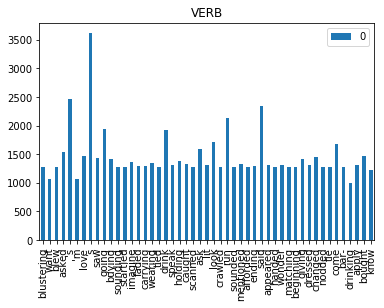

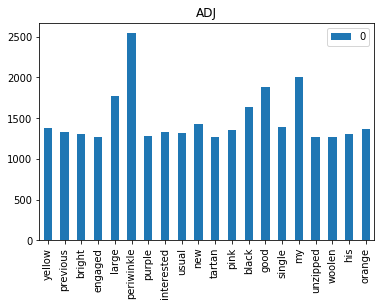

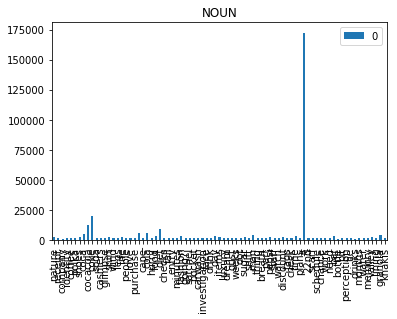

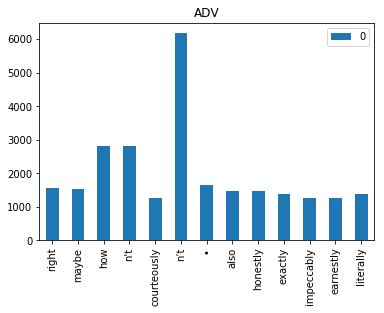

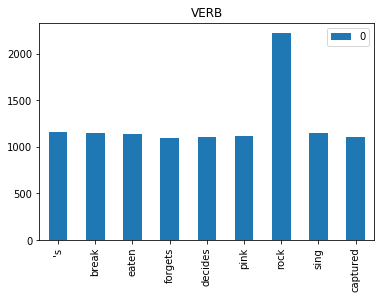

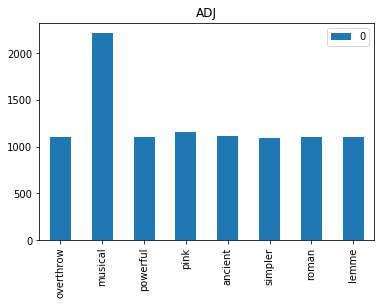

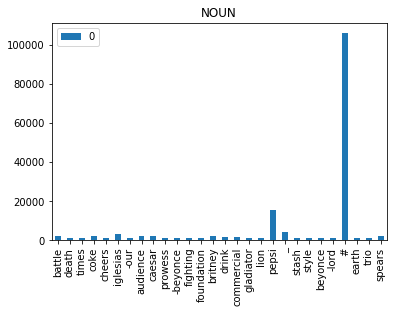

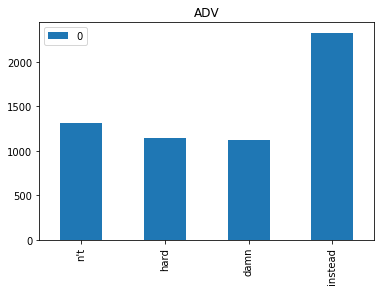

In [10]:
print "Coke Graphs"
for pos in approved_pos:
    counter = Counter(coke_counts[pos])
    counter_df = pd.DataFrame.from_dict(counter, orient="index")
    reduced_count_df = counter_df.loc[counter_df[0] > 1000]
    reduced_count_df.plot(kind="bar", title=pos)
    
print "Pepsi Graphs"
for pos in approved_pos:
    counter = Counter(pepsi_counts[pos])
    counter_df = pd.DataFrame.from_dict(counter, orient="index")
    reduced_count_df = counter_df.loc[counter_df[0] > 1000]
    reduced_count_df.plot(kind="bar", title=pos)


In [11]:
display(counter_df)

,0
r4r,3
all,8
dawnfranklin,41
comically,1
poorly,12
adventure#loveauthentic#wandersession#wanderlust,1
seriously,36
khule,6
dragonballz,2
@,2


Coke Hashtags


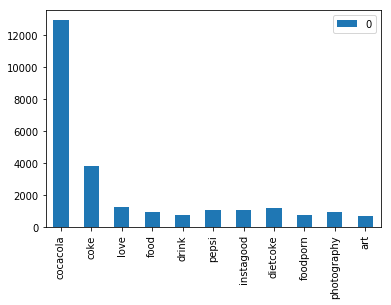

In [25]:
print "Coke Hashtags"
counter = Counter(coke_hash)
counter_df = pd.DataFrame.from_dict(counter, orient="index")
reduced_count_df = counter_df.loc[counter_df[0] > 700]
reduced_count_df.plot(kind="bar")

Pepsi Hashtags


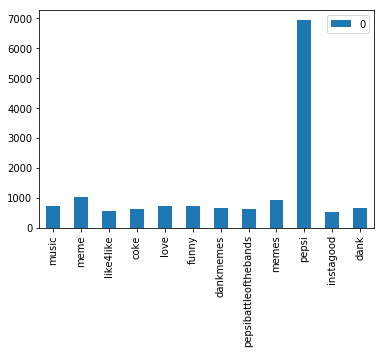

In [24]:
print "Pepsi Hashtags"
counter = Counter(pepsi_hash)
counter_df = pd.DataFrame.from_dict(counter, orient="index")
reduced_count_df = counter_df.loc[counter_df[0] > 500]
reduced_count_df.plot(kind="bar")

## Prompt

In this exercise, you will apply many of the concepts you have learnt in this course to analyze two competing popular soda brands, Coca-Cola and Pepsi. You will be asked to perform a sentiment analysis of the two brands. You will also be asked to parse sentences into parts of speech and extract the Top 100 nouns, verbs, adjectives (of all types) and hashtags by occurrence. In addition to the specific outputs, you will also be asked to answer and summarize with data the following questions:

1. Which brand has more positive sentiment (and by how much: quantify)?

2. What attributes of the product are the reasons why the perception is more positive? (Hint: use specific Parts of Speech)

3. What attributes of each product are the top contributors for their negative perception? (Hint: use specific Parts of Speech)

### Recommended steps


- Tokenize: using sent_tokenize, word_tokenize and TweetTokenizer

- Extract and count sentences that include one of the matching Brands: Coca-Cola or Pepsi

- Perform a sentiment analysis on both Products and print out the overall relative sentiment: using  SentimentIntensityAnalyzer

- Extract all words in sentences by Brand

- Remove stop words

- For each Brand, create lists for the main parts of speech and print Top n words and hashtags in each list using the Part Of Speech (POS) tagger: upenn_tagset

- Create any visualizations you feel would be useful in communicating your findings

- Summarize recommendations for Coke or Pepsi based on your findings


## What David wants to see in the report

- What problem is being solved?
- Who benefits from the problem solution?
- What does the data look like?
- How was the data prepared for modeling?
- What modeling approach did you use?
- What are the resutls
- How did you evaluate the results?
- What next steps would you recommend based on your results?